In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import math
import glob
import os
from scipy.signal import find_peaks
import librosa
import librosa.display
import tgt
import pandas as pd
import seaborn as sn

C:\Users\chain\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\chain\Anaconda3-2019-07\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
def npplot(x, y, x2, y2, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.plot(x2, y2, "xr")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

VIC=10

def cosine_similarity(data):
    cosslist = []
    timeser = []
    #print(data.shape)
    for i in range(data.shape[1]-1):
        u = data[:,i]/np.linalg.norm(data[:,i])
        v = data[:,i+1]/np.linalg.norm(data[:,i+1])
        coss = spatial.distance.cosine(u, v)
        cosslist.append(coss)
        timeser.append(i*0.01)
        #print( "{:.3f}".format(coss), end=" ")        
    #print(i)
    return timeser, cosslist

def vic_similarity(data):
    X=data.shape[1]
    #X=50
    coss = np.empty((X, X))
    for i in range(VIC,X):
        for j in range(VIC):
            u = data[:, i-j]/np.linalg.norm(data[:,i-j])
            v = data[:, i]/np.linalg.norm(data[:,i])
            coss[i-j, i] = spatial.distance.cosine(u, v)
    return coss

def plot_dist_matrix(coss):
    df_cm = pd.DataFrame(coss)
    plt.figure(figsize = (20,14))
    sn.heatmap(df_cm, annot=False)
    plt.show()

In [31]:
FRAME_SIZE=512
WIN_SIZE= 10 # 10 ms

def combined_plot(Y, sr, hop_length, file, time, coss, y_axis="linear"):
    #plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, sr=sr, hop_length=hop_length, x_axis="time", y_axis=y_axis)
    #plt.colorbar(format="%+2.f")
    plt.plot(time, coss)
    plt.title(file)
    plt.show()
    
def plot_spectrogram(Y, sr, hop_length, file, y_axis="linear"):
    #plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, sr=sr, hop_length=hop_length, x_axis="time", y_axis=y_axis)
    #plt.colorbar(format="%+2.f")
    plt.title(file)
    plt.show()

def plot_maxpooling_spec(Y, sr, hop_length, file, y_axis="linear"):
    plot_spectrogram(YMP, sr, hop_length*2, file, y_axis)
    
def get_maxpool_spectrogram(file, needplot=True):
    ylog, sr = get_spectrogramplot(file, needplot=False)
    YMP = skimage.measure.block_reduce(Y, (2,2), np.max)
    if needplot:
        plot_spectogram(YMP, sr, HOP_SIZE, file=file, y_axis="log")
    
def spectrogramplot(file, needplot=True):
    y, sr= librosa.load(file)
    HOP_SIZE= int(WIN_SIZE / (1/sr *1000))
    sff = librosa.stft(y, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    print(sff.shape)
    ysff = np.abs(sff) ** 2
    ylog = librosa.power_to_db(ysff)
    #print(ylog.shape)
    
    if needplot:
        plot_spectrogram(ylog, sr, HOP_SIZE, file=file, y_axis="log")

    return ylog, sr, HOP_SIZE


In [32]:


class mytextgrid:
    def __init__(self, filename="peak.textgrid"):
        if os.path.isfile(filename):
            self.tg = tgt.io.read_textgrid(filename)
        else:
            self.tg = tgt.core.TextGrid()
        
    def add_tier(self, name, duration, peak):
        peaktier = tgt.core.IntervalTier(0, duration, name)
        self.tg.add_tier(peaktier)

        for idx in range(len(peak)):
            if idx == 0:
                ann = tgt.core.Annotation(0, peak[idx], "")
            elif idx == len(peak) - 1:
                ann = tgt.core.Annotation(peak[idx], duration, "")
            else:
                ann = tgt.core.Annotation(peak[idx], peak[idx+1], "")
            peaktier.add_annotation(ann)
        return self.tg

    def export(self, filename):
        tgt.io.write_to_file(self.tg, filename)

(257, 306)


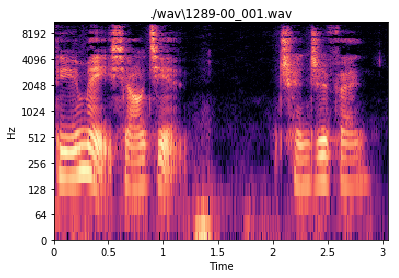

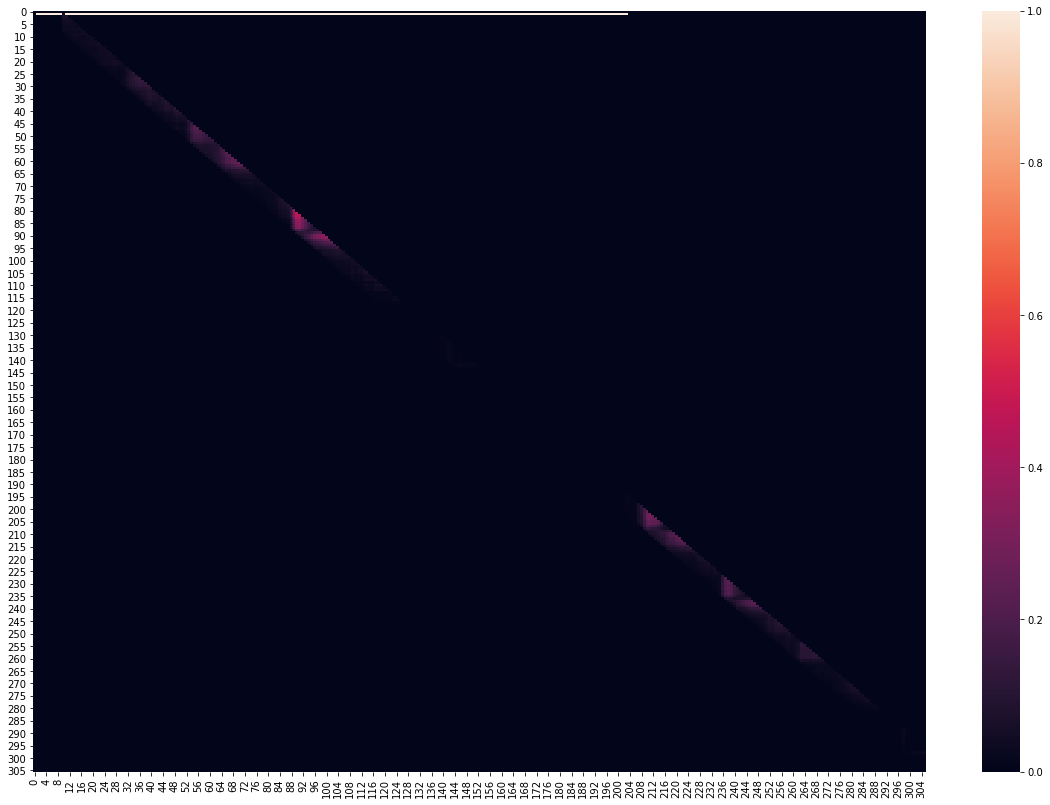

In [33]:
dirpref=r"./wav/*.wav"

def plotspec():
    elef2 = glob.glob(dirpref)
    #print(elef2)
    for f in elef2:
        ylog, sr, hop = spectrogramplot(f, needplot=True)
        coss = vic_similarity(ylog)
        plot_dist_matrix(coss)
        
plotspec()